In [1]:
%load_ext autotime
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
from tqdm.auto import tqdm
from glob import glob
from shapely.geometry import LineString, Point
import folium
pd.set_option('display.max_columns', None)

In [2]:
shorelines = gpd.read_file("Data for testing/NZCCDv1.shp")
shorelines

,Region,Site,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,USDate,SHLength,Date,ID,geometry
0,Auckland,KarekareBethells,MW,2000,tod,RL,4,1,40000,5.03,1.416425,5.620681,01/02/2004,1.265403,2004-01-02,0.0,"LINESTRING Z (1728907.5 5916213.248 0, 1728868..."
1,Auckland,KarekareBethells,MW,2000,tod,RL,4,1,40000,5.03,1.416425,5.620681,01/02/2004,0.307010,2004-01-02,1.0,"LINESTRING Z (1729067.838 5914779.733 0, 17290..."
2,Auckland,KarekareBethells,MW,2000,tod (landward),RL,4,1,40000,5.03,1.416425,5.620681,01/02/2004,0.255243,2004-01-02,2.0,"LINESTRING Z (1729647.881 5911983.994 0, 17296..."
3,Auckland,KarekareBethells,MW,2000,tod,RL,3,1,40000,5.03,1.416425,5.314890,01/02/2004,1.107251,2004-01-02,3.0,"MULTILINESTRING Z ((1728131.079 5917218.888 0,..."
4,Auckland,KarekareBethells,MW,2000,tod,RL,4,1,40000,5.03,1.416425,5.620681,01/02/2004,0.770375,2004-01-02,4.0,"MULTILINESTRING Z ((1729643.228 5912906.682 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19661,West Coast,WoodpeckerBay,MD,1000,EdgeVeg,RL,2,1,18800,4.00,0.630693,3.736680,11/18/1948,1.191368,1948-11-18,19661.0,"LINESTRING Z (1467237.671 5348414.193 0, 14672..."
19662,Otago,Oamaru,TK,1500,Top of cliff,Max,3,2,0,2.02,0.412236,2.278429,04/04/2018,0.650952,2018-04-04,19662.0,"LINESTRING Z (1444386.944 5008247.367 0, 14443..."
19663,Otago,Oamaru,TK,1500,Top of cliff,Max,3,2,0,2.02,0.412236,2.278429,04/04/2018,0.179434,2018-04-04,19663.0,"LINESTRING Z (1444860.629 5008686.925 0, 14448..."
19664,Otago,Oamaru,TK,1500,Top of cliff,Max,3,2,0,2.02,0.412236,2.278429,04/04/2018,0.174825,2018-04-04,19664.0,"LINESTRING Z (1444996.286 5008822.252 0, 14450..."


In [3]:
transects = pd.concat(gpd.read_file(f).set_index("Unique_ID") for f in glob("Data for testing/Unique_ID_transects/*.shp"))
transects

/home/nyou045/retrolens/venv/lib/python3.10/site-packages/pyogrio/raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
/home/nyou045/retrolens/venv/lib/python3.10/site-packages/pyogrio/raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
/home/nyou045/retrolens/venv/lib/python3.10/site-packages/pyogrio/raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
/home/nyou045/retrolens/venv/lib/python3.10/site-packages/pyogrio/raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
/home/nyou045/retrolens/venv/lib/python3.10/site-packages/pyogrio/raw.py:196: UserWarning: M

,geometry
Unique_ID,
1.005226e+11,"LINESTRING Z (1680443.328 5669799.874 0, 16804..."
1.005226e+11,"LINESTRING Z (1680451.296 5669793.831 0, 16804..."
1.005226e+11,"LINESTRING Z (1680459.263 5669787.788 0, 16804..."
1.005227e+11,"LINESTRING Z (1680467.271 5669781.803 0, 16804..."
1.005227e+11,"LINESTRING Z (1680475.694 5669776.413 0, 16804..."
...,...
2.020008e+11,"LINESTRING Z (1616477.032 5429332.43 0, 161634..."
2.020008e+11,"LINESTRING Z (1616467.288 5429330.182 0, 16163..."
2.020008e+11,"LINESTRING Z (1616457.544 5429327.935 0, 16163..."


In [4]:
bbox = gpd.read_file("Data for testing/TestPolygon.shp")
shorelines = shorelines[shorelines.intersects(bbox.geometry[0])]
#shorelines = shorelines.clip(bbox.geometry[0])
m = shorelines.explore()
transects[transects.intersects(bbox.geometry[0])].explore(m=m, color="green")
bbox.boundary.explore(m=m)

<Axes: >

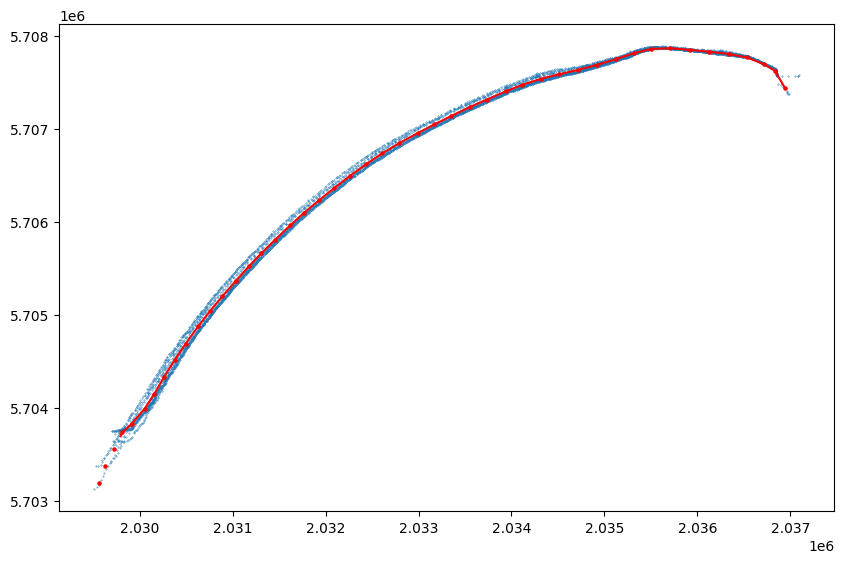

In [5]:
# Hamiltonian path
def sort_points(points):
    center = gpd.GeoSeries(points).union_all().envelope.centroid
    points = points.to_list()
    start_point = max(points, key=lambda point: point.distance(center))
    sorted_points = [start_point]
    points.remove(start_point)

    while len(points) > 0:
        last_point = sorted_points[-1]
        nearest_point = min(points, key=lambda point: point.distance(last_point))
        points.remove(nearest_point)
        sorted_points.append(nearest_point)
    return gpd.GeoSeries(sorted_points)

points = []
for shoreline in shorelines.geometry:
    points.extend([Point(p) for p in shoreline.coords])

numpy_points = np.array([[p.x, p.y] for p in points])
tree = KDTree(numpy_points)
radius = 200
average_points = []
visited = set()

for i, point in enumerate(numpy_points):
    if i in visited:
        continue
    indices = tree.query_ball_point(point, radius)
    cluster_points = numpy_points[indices]
    mean_point = np.mean(cluster_points, axis=0)
    average_points.append(Point(mean_point))
    visited.update(indices)

average_points = gpd.GeoSeries(average_points, crs=shorelines.crs)
smoothed_shoreline = gpd.GeoSeries(LineString(sort_points(average_points)), crs=shorelines.crs)
smoothed_shoreline = smoothed_shoreline.clip(bbox.geometry[0])

ax = gpd.GeoSeries(points, crs=shorelines.crs).plot(figsize=(10, 10), markersize=.1)
gpd.GeoSeries(average_points, crs=shorelines.crs).plot(ax=ax, color="red", markersize=5)
smoothed_shoreline.plot(ax=ax, color="red")

In [7]:
def create_transects(line, spacing=10, transect_length=400):
    transects = []
    distances = np.arange(0, line.length, spacing)

    for distance in distances:
        # Find point along the average line
        point = line.interpolate(distance)
        
        # Find the direction of the line at this point (tangent direction)
        nearest_point_ahead = line.interpolate(min(distance + 1e-6, line.length))
        direction = np.arctan2(nearest_point_ahead.y - point.y, nearest_point_ahead.x - point.x)
        
        # Rotate 90 degrees (perpendicular) and extend to create a transect
        transect = LineString([
            Point(
                point.x - transect_length / 2 * np.cos(direction + np.pi / 2),
                point.y - transect_length / 2 * np.sin(direction + np.pi / 2)
            ),
            Point(
                point.x + transect_length / 2 * np.cos(direction + np.pi / 2),
                point.y + transect_length / 2 * np.sin(direction + np.pi / 2)
            )
        ])
        
        transects.append(transect)
    
    return transects

my_transects = create_transects(smoothed_shoreline.geometry.iloc[0])
my_transects = gpd.GeoDataFrame(geometry=my_transects, crs=shorelines.crs)
m = shorelines.explore(name="shorelines")
transects[transects.intersects(bbox.geometry[0])].explore(m=m, color="green", name="DSAS transects")
transects.geometry[transects.intersects(bbox.geometry[0])].apply(lambda line: Point(line.coords[0])).explore(m=m, color="green", name="DSAS transect start")
bbox.boundary.explore(m=m, name="bbox")
smoothed_shoreline.explore(m=m, color="red", name="smoothed shoreline")
my_transects.explore(m=m, color="red", name="generated transects")
gpd.GeoSeries(my_transects.geometry.apply(lambda line: Point(line.coords[0])), crs=shorelines.crs).explore(m=m, color="red", name="transect start")
folium.LayerControl(collapsed=False).add_to(m)
m